# Modules

In [101]:
import missingno  as msno
import seaborn as sns
import matplotlib.pyplot as plt

## Get data

In [6]:
import json
import pandas as pd
from sodapy import Socrata
from datetime import datetime,timedelta


class Get_Data():
    def __init__(self, df= pd.DataFrame()):
        self.df= df
    
    def create_df(self):
        
        client = Socrata("data.lacity.org", None)
        results = client.get("2nrs-mtv8", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd.csv')
        self.df = results_df
    
    
    def create_df_n_days(self,n):
        client = Socrata("data.lacity.org", None)
        # filtro para traer los ultimos n días
        date_filter = (datetime.utcnow() - timedelta(days=n)).strftime("%Y-%m-%dT%H:%M:%S.%f")
        results = client.get("2nrs-mtv8", where=f"date_rptd >= '{date_filter}'", limit=800000)
        results_df = pd.DataFrame.from_records(results)
        results_df.to_csv(r'lapd_'+str(n)+'_days.csv')
        self.df = results_df       

        
    def infer_dtypes(self):
        ls_dates=["date_rptd", "date_occ"]
        ls_numeric=["vict_age","lat", "lon"]
        ls_strings=[x for x in self.df.columns if x not in ls_dates+ls_numeric]
        for date in ls_dates:
            self.df[date]= pd.to_datetime(self.df[date])
        for num in ls_numeric:
            self.df[num]= pd.to_numeric(self.df[num])
        for s in ls_strings:
            self.df[s].apply(lambda x: str(x).split(','))
        self.df["time_occ"]=self.df["time_occ"].apply(lambda x: int(x[0:2])*60+int(x[2:]))

In [7]:
data_loader= Get_Data()

In [8]:
data_loader.create_df_n_days(20)

In [11]:
data_loader.infer_dtypes()

In [12]:
data=data_loader.df

## Clenaner

In [114]:
from pandas import DataFrame, read_excel, read_csv
from numpy import nan
import csv
import pickle


class ProductionCleaner():

    def __init__(self,data):
        self.df=data.copy()

        
    def manageNan(self):
        # fill nan's and typos
        #self.df.loc[self.df.vict_age==0,'vict_age']=nan
        #self.df.loc[(self.df.vict_age<0)|(self.df.vict_age>100),'vict_age']=nan
        self.df['weapon_used_cd'].fillna('0',inplace=True)
        #self.df["premis_cd"].fillna('746',inplace=True)
        self.df.loc[self.df.vict_sex.isna(),'vict_sex']='X'
        self.df.loc[self.df.vict_sex=='H','vict_sex']=='X'
        self.df.loc[self.df.vict_descent.isna(),'vict_descent']='U'
        self.df.loc[self.df.lon==0,['lat','lon']]=nan
    
    def dropColumns(self):
        # Drop columns
        self.df.drop(['crm_cd_1','crm_cd_2','crm_cd_3','crm_cd_4','area_name','time_occ',
                      'crm_cd_desc','premis_desc','weapon_desc', 'status_desc','area_name',
                      'date_occ','area','rpt_dist_no','part_1_2','mocodes', "vict_age"],axis=1,inplace=True)
        try:
            self.df.drop(self.df.loc[self.df.status=='CC'].index,inplace=True)
        except:
            pass
        
    def manageLocation(self):
        # Delete spaces
        self.df.location = self.df.location.str.strip()
        self.df.location = self.df.location.apply(lambda x: "  ".join(x.split()))
        self.df.location = self.df.location.str.replace(" ", "")
        self.df.location = self.df.location.str.upper()
        # Replace with dictonary values
        directorio = read_csv('Data/Cleaner/Directorio_Lat_Lon.csv')
        directorio.location = directorio.location.str.replace(" ", "")
        directorio.location = directorio.location.str.upper()
        loc_lat = dict(zip(directorio.location,directorio.lat))
        loc_lon = dict(zip(directorio.location,directorio.lon))
    
        # Verificar si las columnas "lat" o "lon" tienen valores faltantes
        mask = self.df['lat'].isna() | self.df['lon'].isna()
        # Verificar si los valores de la columna "location" están en las claves del diccionario "loc_lat"
        not_found = ~self.df.loc[mask, 'location'].isin(loc_lat.keys())
        self.df.loc[mask & ~not_found, 'lat'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lat)
        self.df.loc[mask & ~not_found, 'lon'] = self.df.loc[mask & ~not_found, 'location'].map(loc_lon)
        ## Aqui duda, borramos los que no estan en el diccionario y son nulos o que sugieren?
        self.df.drop('location',axis=1,inplace=True)
        
    def clean(self):
        ## Esta funcion ya nos deja los datos sin nulos
        self.df.drop('cross_street',axis=1,inplace=True)
        self.manageNan()
        self.dropColumns()
        print(self.df.columns)
        self.manageLocation()
        
    
            
    def clipping(self):
        self.df['lon']=self.df['lon'].clip(-118.7, -118.1)
        self.df['lat']=self.df['lat'].clip(33.6, 34.4)
        
    def lugar(self):
        pl=[[[119,120,121,145,146.0,150.0,501.0, 502.0, 504.0,507.0, 508.0, 509.0, 510.0,511,515.0, 516.0,707],['vivienda']],
            [[101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 109.0, 110.0,116,117,
              124.0, 125.0,128,136.0, 137.0,152,154,158,415,705.0,748.0],['calle']],
            [[725.0, 726.0,240.0,732.0,752,753,756.0],['gobierno']],
            [[123,142,156,204.0, 213.0],['estacionamiento']],
            [[151.0,157.0,238,241,254,302,303,304.0, 305.0,702],['establecimiento']],
            [[201.0, 202.0, 203.0,205.0, 206.0,208,209.0, 210.0, 211.0,217.0, 218.0,
                                219.0, 220.0, 221.0, 222.0, 223.0, 224.0, 225.0,228,233.0,242,244.0, 245.0,
                                247.0, 248.0, 249.0,250.0, 251.0, 252.0,255,401.0, 402.0, 404.0, 405.0,
                                406.0, 407.0, 408.0,409.0, 410.0, 411.0, 412.0, 413.0, 414.0,417.0,703,
                                148.0,709,301,216
                                ],['establecimiento_publico']],
            [[207,706.0,733.0,735.0],['nocturno']],
            [[503,505,519.0],['hotel']],
            [[111.0, 112.0, 113.0, 114.0, 115.0,122,126,212.0, 214.0, 215.0,801.0, 802.0,804,809.0, 810.0,
                 811.0, 834.0, 835.0, 836.0, 868.0, 869.0, 870.0, 871.0, 872.0, 873.0,
                 874.0, 875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 882.0, 883.0, 884.0,
                                885.0, 889.0, 890.0, 891.0, 892.0, 893.0, 894.0, 895.0, 896.0, 897.0,
                                898.0, 900.0, 901.0, 902.0, 903.0, 904.0, 905.0, 906.0, 907.0, 908.0,
                                909.0, 910.0, 911.0, 912.0, 913.0, 915.0, 916.0, 917.0, 918.0, 919.0,
                                920.0, 921.0, 922.0, 931.0, 932.0, 933.0, 934.0, 935.0, 936.0, 937.0,
                                940.0, 941.0, 942.0, 943.0, 944.0, 945.0, 946.0, 947.0, 948.0, 949.0,
                                950.0, 951.0, 952.0, 953.0, 954.0, 956.0, 957.0, 958.0, 961.0, 962.0,
                                963.0, 964.0, 965.0, 966.0, 967.0, 968.0, 969.0, 970.0, 971.0,129,135
                               ],['transporte']],
            [[138,143,727,140],['escaleras']],
            [[139,108,147.0,712.0,713,144,714.0, 715.0, 716.0, 717.0, 718.0,711,734.0, 736.0, 737.0, 738.0, 739.0,
                  742.0, 743.0,754,757.0, 758.0],['recreacion']],
            [[141,149,155,745.0,107.0,118,506.0,518.0,127],['espacio_abierto']],
            [[227.0,234.0, 235.0, 236.0, 237.0,239,246.0,253,403,701.0,719,755],['medico']],
            [[229,601,602.0, 603.0, 604.0, 605.0, 606.0, 607.0, 608.0],['financiero']],
            [[230.0, 512.0,514,517],['cuidado_personas']],
            [[231.0,704.0,720.0, 721.0, 722.0, 723.0,724.0,729],['escuela']],
            [[232.0,245.0,513,710,744.0,746.0],['otro']],
            [[709.0, 730.0, 731.0,740],['iglesia']],
            [[750.0, 751.0],['internet']]]
        premis=[]
        for secc in pl:
            premis+=list(zip(secc[0],secc[1]*len(secc[0])))
        premis=dict(premis)
        self.df.premis_cd= self.df.premis_cd.astype("float")
        self.df['premis']=self.df["premis_cd"].apply(lambda x: premis[x] if x in premis.keys() else "otro")
    def zonas(self):
        clusters=pickle.load(open('models/Cleaner/cluster5.sav','rb'))
        self.df['zonas']=clusters.predict(self.df[['lat','lon']])
    def categorias(self):
        columnas=['weapon_used_cd','premis']
        for col in columnas:
            with open("Data/Cleaner/"+col+"categorias", "rb") as fp:  
                lista = pickle.load(fp)
            self.df[col]=self.df[col].apply(lambda x: x if x in lista else 'Others')
    def simple_imp(self):
        with open("Data/Cleaner/imputer_mode", "rb") as fp:
            imputador= pickle.load(fp)
        self.df[['premis_cd','crm_cd','status']]=imputador.transform(self.df[['premis_cd','crm_cd','status']])
    def super_clases(self):
        temp=read_csv('Data/Cleaner/crcd_Spcls.csv')
        temp.drop('NewCode',axis=1,inplace=True)
        self.df=self.df.merge(temp, how='left', left_on='crm_cd', right_on='crm_cd')
        self.df.drop('crm_cd',axis=1,inplace=True)
        self.df.rename(columns = {'Superclass':'crime'}, inplace = True)


### Clean

In [115]:
cleaner= ProductionCleaner(data)

In [116]:
cleaner.clean()

Index(['dr_no', 'date_rptd', 'crm_cd', 'vict_sex', 'vict_descent', 'premis_cd',
       'status', 'location', 'lat', 'lon', 'weapon_used_cd'],
      dtype='object')


<Axes: >

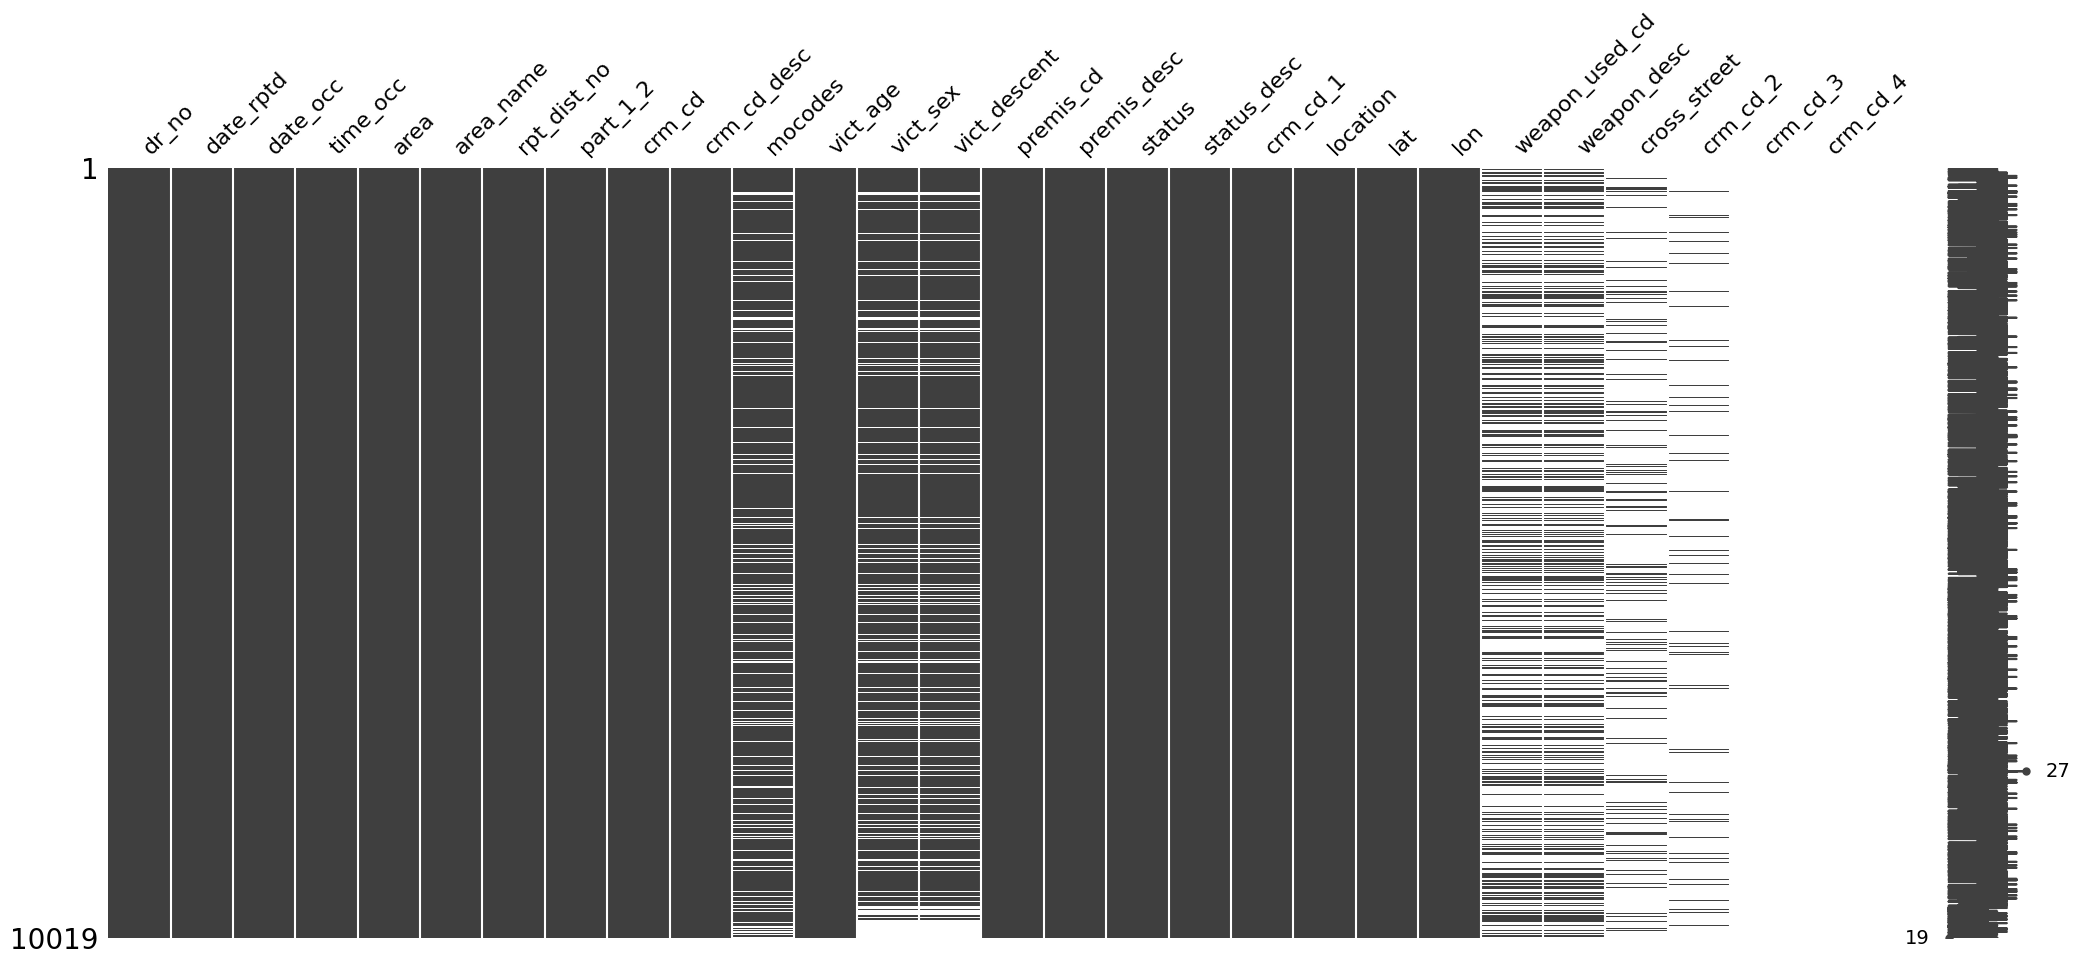

In [117]:
msno.matrix(data)

<Axes: >

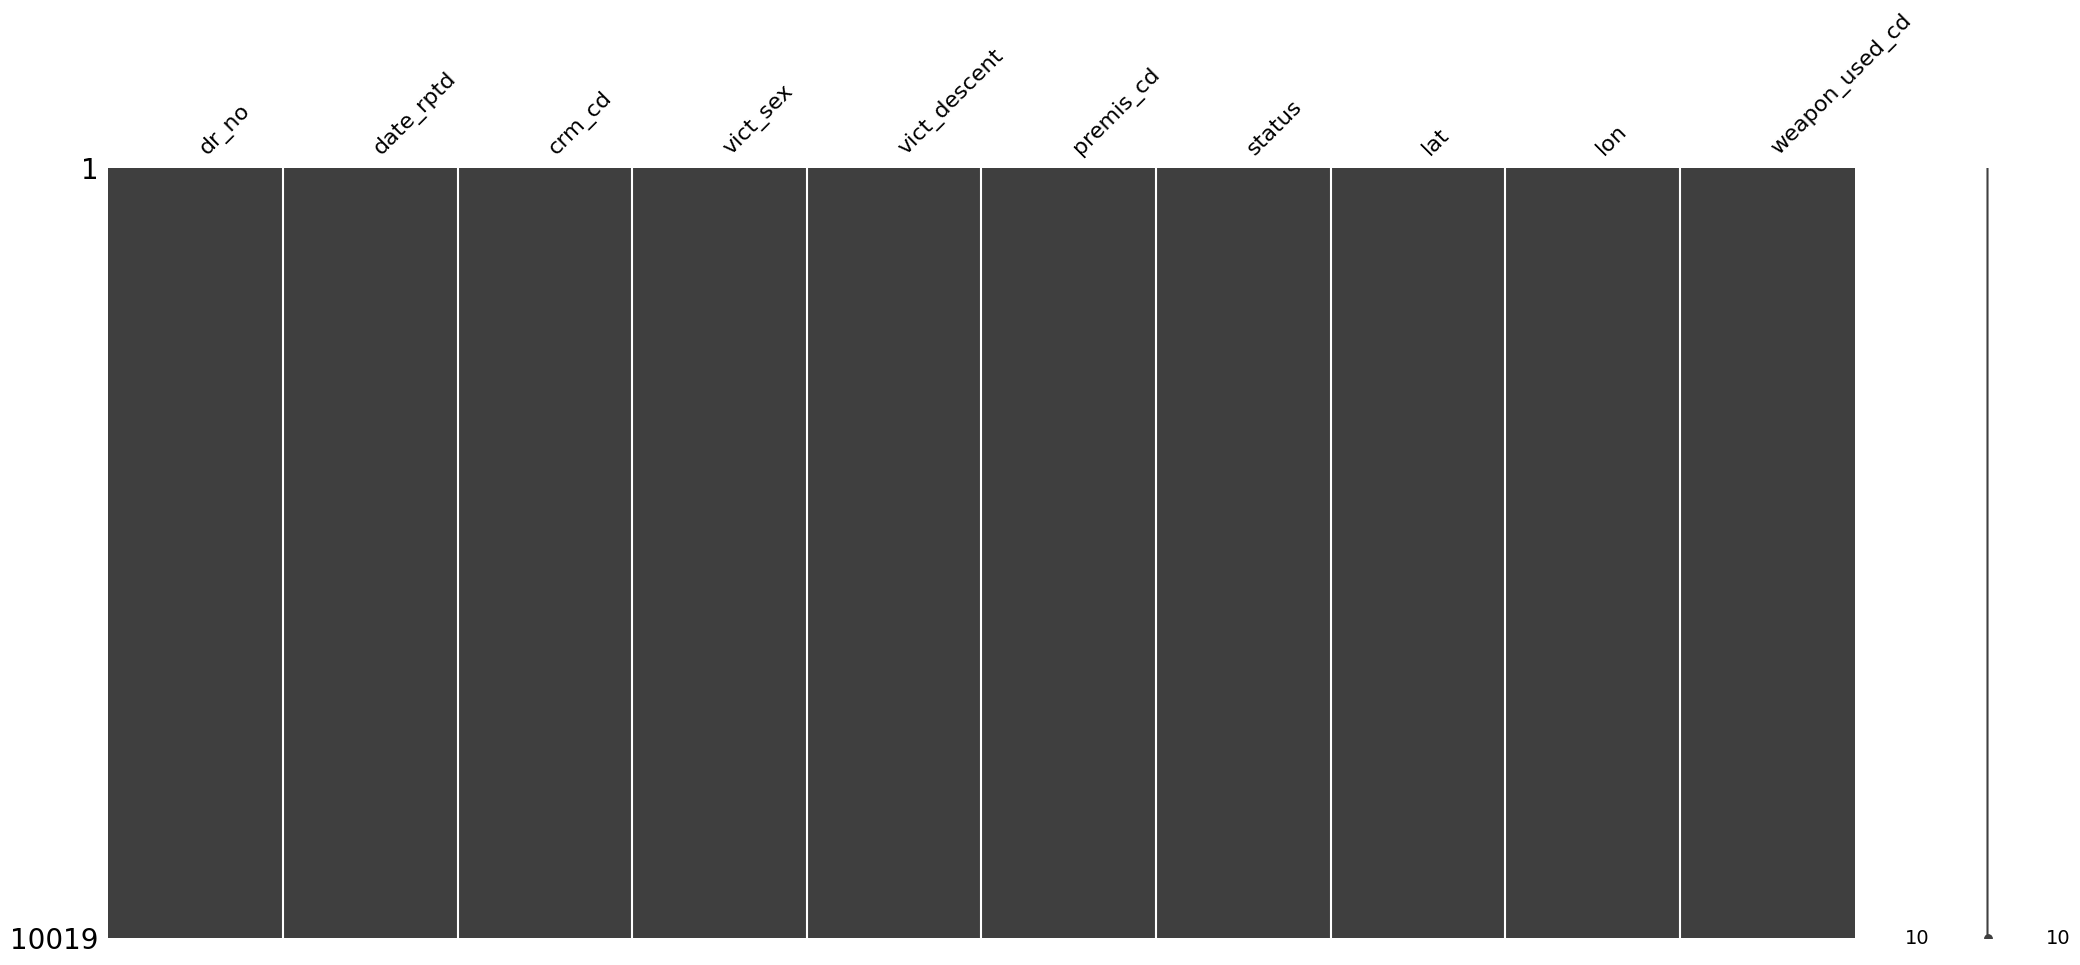

In [118]:
msno.matrix(cleaner.df)

### Clipping

In [119]:
cleaner.clipping()

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'date_occ'}>],
       [<Axes: title={'center': 'time_occ'}>,
        <Axes: title={'center': 'vict_age'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>]],
      dtype=object)

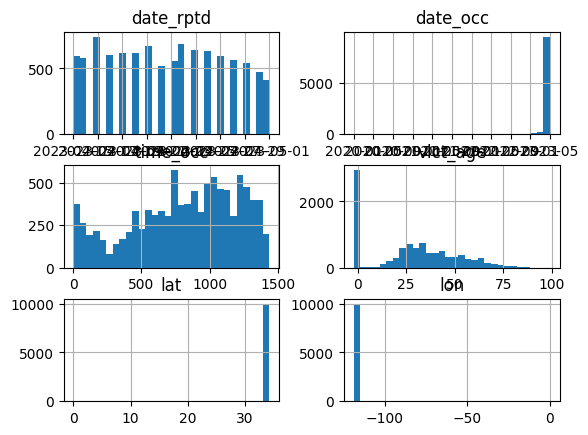

In [120]:
data.hist(bins=30)

array([[<Axes: title={'center': 'date_rptd'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lon'}>, <Axes: >]], dtype=object)

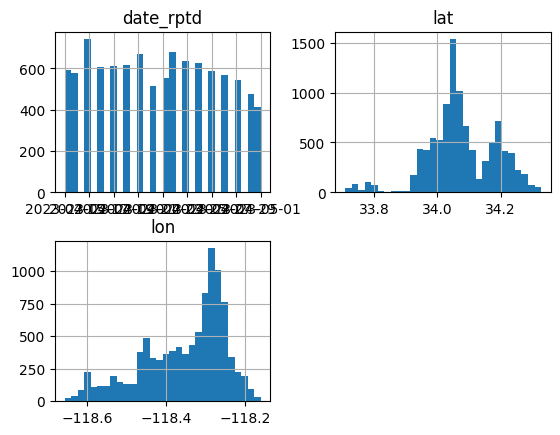

In [121]:
cleaner.df.hist(bins=30)

### Imputación

In [122]:
cleaner.simple_imp()

/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AttributeError: 'SimpleImputer' object has no attribute 'keep_empty_features'

### Lugar

In [95]:
cleaner.lugar()

<Axes: xlabel='premis_cd', ylabel='count'>

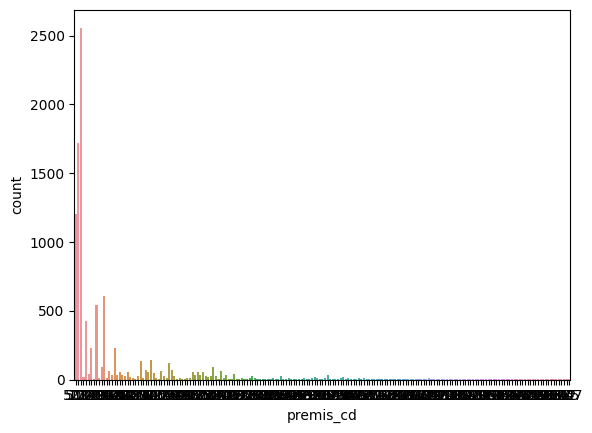

In [96]:
sns.countplot(data, x="premis_cd")

<module 'matplotlib.pyplot' from '/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/matplotlib/pyplot.py'>

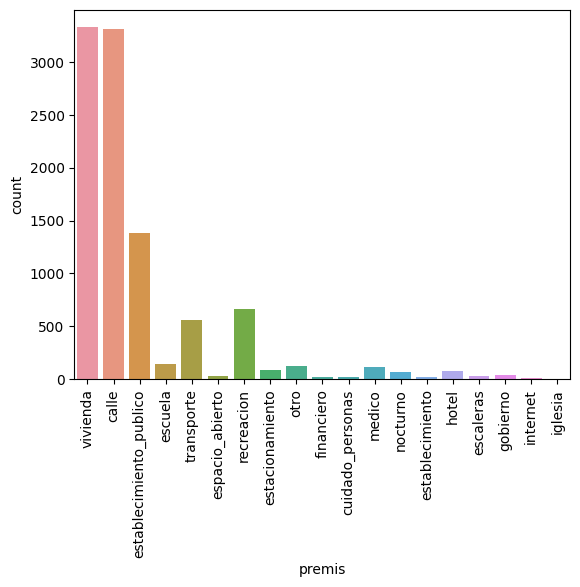

In [98]:
g=sns.countplot(cleaner.df,x="premis")
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt

### Zonas

In [102]:
cleaner.zonas()

/home/bluterplay/jupyter/vlapd/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [105]:
cleaner.df["zonas"].value_counts()/len(cleaner.df)

0    0.501148
1    0.175367
3    0.168280
2    0.117177
4    0.038028
Name: zonas, dtype: float64

## Test